### US Foods Assessment
#### Julian Carrasquillo
#### 2023-04-24

Resources

* [Understanding 20newsgroups and Reading in](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)
* Word2Vec
    * [word2vec Tutorial](https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/)
    * [word2vec usage examples](https://radimrehurek.com/gensim/models/word2vec.html)
* [Using BERT for Classification](https://www.youtube.com/watch?v=hOCDJyZ6quA&t=1264s)
* [SO: Building combinations of dictionary of lists](https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python)

----------------------

Table of Contents

* [Base Tutorial](#Base-Tutorial)
* [Grid Search on Hyperparameters](#Grid-Search-on-Hyperparameters)
* [Word2Vec](#Word2Vec)
* [Trying Out an LLM](#Trying-Out-an-LLM)
* [Next Steps](#Next-Steps)

In [35]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
RANDOM_SEED = 42

### Base Tutorial

The tutorial gave a great look into the best ways to read in the data. Removing headers, footers, and quotes helps to make more generalizable models since a lot can be gleaned from these fields. For example, having a university email in a signature tends to lean towards science-based articles.

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'))

len(newsgroups_train['data'])

11314

From the tutorial, we can use sklearn's built in `TfidfVectorizer`, which builds a sparse matrix based on a balance between a token's term frequency and its inverse document frequency. This weights each token by a measure of relevance to a specific document and relevance to the entire corpus. We can verify the matrix size by checking the output `vectors` shape. The number of rows aligns with the number of articles downloaded.

In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(11314, 101631)

The tutorial uses a multinomial naive bayes classifier. This trains by counting the number of times each word appears in each category. When we're inferring, a document's words are scored with the most represented category being the prediction. This approach is considered naive because there is assumed independence between words. The model does ok with this dataset, accomplishing an accuracy of ~0.7002.

In [5]:
clf = MultinomialNB(alpha = .01)
clf.fit(vectors,  newsgroups_train.target)

newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'))

vectors_test = vectorizer.transform(newsgroups_test.data)
pred = clf.predict(vectors_test)
print(metrics.accuracy_score(pred, newsgroups_test.target))

0.7002124269782263


## Grid Search on Hyperparameters

Between the `TfidfVectorizer` and `MultinomialNB` objects, we have a few hyperparameters we can explore to improve performance. We can build out our own grid search algorithm to try out different combinations and store the results. We'll leverage a function that takes in the various objects along with their parameter set. 

In [6]:
def train_classifier(train, vectorizer, classifier, vectorizer_params = {}, classifier_params = {}):
    vectorizer = vectorizer(**vectorizer_params)
    vectors = vectorizer.fit_transform(train['data'])
    
    clf = classifier(**classifier_params)
    clf.fit(vectors, train['target'])
    
    return vectorizer, clf

def test_classifier(test, vectorizer, classifier):
    vectors = vectorizer.transform(test['data'])
    pred = classifier.predict(vectors)
    return metrics.accuracy_score(pred, test['target'])

In [7]:
# verify we get the same results as above
vectorizer, clf = train_classifier(newsgroups_train, vectorizer = TfidfVectorizer, classifier = MultinomialNB, classifier_params = {'alpha' : .01}) 
test_classifier(newsgroups_test, vectorizer, clf)

0.7002124269782263

Using python's built-in `itertools`, we can build combinations of parameters for both our vectorizer and algorithms. Using the string as a key for the algorithm, we can include the actual algorithm object from `sklearn` to be passed to our code. Some explanations of the hyperparameters are below:

### from `TfidfVectorizer`

#### `ngram_range`

We can see if opening up the word count of each token has any positive effects. Out of the box, `TfidfVectorizer` takes single words as tokens (unigrams). We can expand this to include any arbitrary group of words (2 word combinations = bigrams, 3 words = trigrams, etc) to get some more context. Some examples for why this can be helpful:

* we can better capture a baseball players full name - `Jorge` & `Posada` mean more together and more heavily imply an article about baseball.
* we can get nuanced differences between things like  `climate change` and the current `political climate`

#### `max_df`

This parameter essentially acts like a stop word list where the list is generated from the corpus itself. It removes any tokens that show up too many times. As a value between `0` and `1`, it removes any words that show up in more than that proportion of documents.

### from `MultinomialNB`

#### `alpha`

This parameter helps with smoothing. Essentially supports situations where the model may see a new word in the test set.

In [8]:
import itertools

vector_grid = { 'ngram_range'  : [(1, 1), (1, 2), (2, 2)],
               'max_df' : [0.7, 0.8, 0.9, 1.0]}

algo_grid = {'MultinomialNB' : {'algo_obj' : MultinomialNB,
                                'params' : {'alpha' : [0.01, .05,  0.1, 0.5,  1]}}}

In [9]:
# From https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python
keys, values = zip(*vector_grid.items())
vector_groups = [dict(zip(keys, v)) for v in itertools.product(*values)]
vector_groups

[{'ngram_range': (1, 1), 'max_df': 0.7},
 {'ngram_range': (1, 1), 'max_df': 0.8},
 {'ngram_range': (1, 1), 'max_df': 0.9},
 {'ngram_range': (1, 1), 'max_df': 1.0},
 {'ngram_range': (1, 2), 'max_df': 0.7},
 {'ngram_range': (1, 2), 'max_df': 0.8},
 {'ngram_range': (1, 2), 'max_df': 0.9},
 {'ngram_range': (1, 2), 'max_df': 1.0},
 {'ngram_range': (2, 2), 'max_df': 0.7},
 {'ngram_range': (2, 2), 'max_df': 0.8},
 {'ngram_range': (2, 2), 'max_df': 0.9},
 {'ngram_range': (2, 2), 'max_df': 1.0}]

In [10]:
algo_groups = {}
for item in algo_grid.keys():
    keys, values = zip(*algo_grid[item]['params'].items())
    algo_groups.update({item : [dict(zip(keys, v)) for v in itertools.product(*values)]})

algo_groups

{'MultinomialNB': [{'alpha': 0.01},
  {'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.5},
  {'alpha': 1}]}

Now that our combinations are set up, we can loop through them with our train / test functions and keep track of our results. We extract a validation set from our training data in order to leave the test set as a true evaluator.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(newsgroups_train.data, newsgroups_train.target,  test_size = 0.2, random_state = RANDOM_SEED, stratify = newsgroups_train.target)

hp_train = {'data' : X_train, 'target' :  y_train}
hp_val = {'data' : X_val, 'target' :  y_val}

In [12]:
results = {}
i = 0
for vector_combo in vector_groups:
    for key, value in algo_groups.items():
        for algo_param in value:
            vectorizer, clf = train_classifier(hp_train, vectorizer = TfidfVectorizer, classifier = algo_grid[key]['algo_obj'], vectorizer_params = vector_combo, classifier_params = algo_param)
            results.update({i : {'vector_combo' : vector_combo, 'algo' : key, 'algo_param' : algo_param, 'accuracy' : test_classifier(hp_val, vectorizer, clf)}})
            i = i + 1

In [13]:
results_df = pd.DataFrame(results)
best_combo = results_df[np.argmax(results_df.loc['accuracy'])]
best_combo

vector_combo    {'ngram_range': (1, 1), 'max_df': 0.7}
algo                                     MultinomialNB
algo_param                             {'alpha': 0.01}
accuracy                                      0.771984
Name: 0, dtype: object

In [14]:
vectorizer, clf = train_classifier(newsgroups_train, vectorizer = TfidfVectorizer, classifier = MultinomialNB, vectorizer_params = best_combo['vector_combo'], classifier_params = best_combo['algo_param'])
test_classifier(newsgroups_test, vectorizer, clf)

0.700477960701009

This improved accuracy by a very small amount of about 0.0002 for this subset. It looks like increasing the word counts in a token did not add value, but removing words showing up in more than 70% of the documents did. From the algorithm perspective, increasing smoothing parameter looks to have helped. 

To investigate further, we can see what words are most associated with each category using the below function from the sklearn tutorial. Unfortunately, we see many words that we'd expect to be excluded with the max_df parameter. Another approach is to try using the built-in stop_word function to see if we improve results. 

In [15]:
# From https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.feature_log_prob_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [16]:
show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: be are not in and it you is that of
comp.graphics: on that you in graphics it is for and of
comp.os.ms-windows.misc: that in file of you for and is it windows
comp.sys.ibm.pc.hardware: that have with scsi for of drive is it and
comp.sys.mac.hardware: you with that apple for of mac it and is
comp.windows.x: server motif for this it in of is and window
misc.forsale: it of or in shipping offer 00 and sale for
rec.autos: for on is that in it of you and car
rec.motorcycles: is my for that in of you it and bike
rec.sport.baseball: his they year was is that of in and he
rec.sport.hockey: is was hockey team that game of he and in
sci.crypt: encryption this in be it is that key and of
sci.electronics: this on that for in it you is and of
sci.med: be are this you that in it and is of
sci.space: you be for that it is in and space of
soc.religion.christian: we not you it in god and is that of
talk.politics.guns: this they it gun is you in and that of
talk.politics.mideast: are not it 

In [17]:
vectorizer, clf = train_classifier(newsgroups_train, vectorizer = TfidfVectorizer, classifier = MultinomialNB, vectorizer_params = {'stop_words' : 'english'}, classifier_params = best_combo['algo_param'])
test_classifier(newsgroups_test, vectorizer, clf)

0.7010090281465746

In [18]:
show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: islam atheists say just religion atheism think don people god
comp.graphics: looking format 3d know program file files thanks image graphics
comp.os.ms-windows.misc: card problem thanks driver drivers use files dos file windows
comp.sys.ibm.pc.hardware: monitor disk thanks pc ide controller bus card scsi drive
comp.sys.mac.hardware: know monitor does quadra simms thanks problem drive apple mac
comp.windows.x: using windows x11r5 use application thanks widget server motif window
misc.forsale: asking email sell price condition new shipping offer 00 sale
rec.autos: don ford new good dealer just engine like cars car
rec.motorcycles: don just helmet riding like motorcycle ride bikes dod bike
rec.sport.baseball: braves players pitching hit runs games game baseball team year
rec.sport.hockey: league year nhl games season players play hockey team game
sci.crypt: people use escrow nsa keys government chip clipper encryption key
sci.electronics: don thanks voltage used know does lik

This improved a better amount from last attempt - both in accuracy and more defining words to differentiate topics. Looking at individual categories, the model does best with baseball, middle eastern politics, and science articles. We can visualize the confusion matrix to get a good sense of which categories performed better and which were less successful.

In [36]:
vectors = vectorizer.transform(newsgroups_test['data'])
pred = clf.predict(vectors) 

From the confusion matrix and overall classification metrics, there were a handful of categories that performed particularly well - `rec.sport.hockey`, `soc.religion.christian`, `sci.space` and `sci.med`. The `talk.religion.misc` category performed the worst, with most of the missed classes going to `alt.atheism` and the other `talk.` groups.

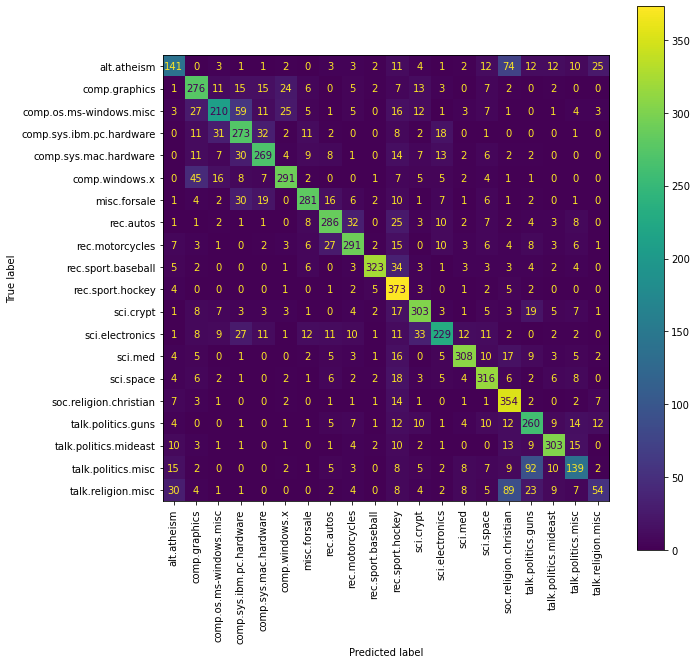

In [39]:
cm = metrics.confusion_matrix(newsgroups_test['target'], pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=newsgroups_test['target_names'])
disp.plot()
plt.xticks(rotation = 90)
plt.show()

In [37]:
print(metrics.classification_report(pred, newsgroups_test['target'], target_names = newsgroups_test['target_names'] ))

                          precision    recall  f1-score   support

             alt.atheism       0.44      0.59      0.51       239
           comp.graphics       0.71      0.66      0.68       419
 comp.os.ms-windows.misc       0.53      0.69      0.60       304
comp.sys.ibm.pc.hardware       0.70      0.60      0.65       452
   comp.sys.mac.hardware       0.70      0.73      0.71       371
          comp.windows.x       0.74      0.80      0.77       365
            misc.forsale       0.72      0.80      0.76       352
               rec.autos       0.72      0.75      0.74       380
         rec.motorcycles       0.73      0.75      0.74       386
      rec.sport.baseball       0.81      0.93      0.87       347
        rec.sport.hockey       0.93      0.59      0.72       634
               sci.crypt       0.77      0.73      0.75       414
         sci.electronics       0.58      0.72      0.65       317
                 sci.med       0.78      0.84      0.81       365
         

## Word2Vec

The estimators in sklearn lean on traditional NLP techniques - bag of words and TF-IDF. We can leverage newer, transformer-based approaches to try and get some context from various words through the use of an attention mechanism.

We will try to build our own embeddings using the corpus.

In [42]:
! pip install nltk
! pip install gensim


[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached gensim-4.3.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)

[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [53]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In this process, we take each document and parse it into sentences and then parse those into words. We then append all of the lowercase words into a data list that is passed to the `Word2Vec` function. We're able to set the vector size and window, but we'll use the values from the tutorial for now.

In [44]:
data = []

for i, item in enumerate(newsgroups_train['data']):
    item_clean = item.replace("\n", " ")
    for j in sent_tokenize(item_clean):
        temp = []
        # tokenize the sentence into words
        for k in word_tokenize(j):
            temp.append(k.lower())
            
        data.append(temp)

In [45]:
newsgroups_w2v = gensim.models.Word2Vec(data, min_count = 1,
                              vector_size = 100, window = 5)
newsgroups_w2v.save("word2vec.wordvectors")

Now that we have a custom vectorizer, we need to go through our training and test data to convert the documents. Because we word has a vector representation, we can sum the vectors across a document to get a representation. We have some handling components that add a vector of 0s if a doc is empty or if a word not seen before is found.

`print_int_instance` is a helper function that shows where any non-array entries show up from a given corpus. 

In [46]:
def convert_to_vector(data, w2vModel, dim):
    """
    Takes data from the newsgroups_20 set and converts each document into a singular vector
    
    data: the ['data'] component from the train or test set 
    w2vModel: object representing word-vector lookup. Can be the .wv object or the KeyedVector object
    dim int: the dimension of the expected returned vector. This allows us to fill missing vocabulary with a vector that plays nice with the ultimate output 
    """
    doc_vectors = []
    for doc in data:
        word_vectors = []
        if doc.strip() == "":
            word_vectors.append(np.zeros((dim,)))
        else:
            for word in word_tokenize(doc):
                word_clean = word.replace("\n", " ").lower()
                try:
                    word_vectors.append(w2vModel[word_clean])
                except KeyError:
                    word_vectors.append(np.zeros((dim,)))
        doc_vectors.append(sum(word_vectors))
    return doc_vectors

def print_int_instance(a_list):
    """
    Prints out the index of each element of a list that is an integer 
    """
    for i, item in enumerate(a_list):
        if isinstance(item, int):
            print("Int at index:", i)
            print(item)

In [47]:
homebrew_train = convert_to_vector(data = newsgroups_train['data'], w2vModel = newsgroups_w2v.wv, dim = 100)

In [48]:
print_int_instance(homebrew_train)

Because our vectorizer produces negative components, we can't use `MultinomialNB` as a classifier with the outputs as is. We can definitely introduce a scaler like `MinMaxScaler` from sklearn, but we can also just use another algorithm. I like tree-based models, so I'll try `RandomForestClassifier`.

In [49]:
clf = RandomForestClassifier(random_state = RANDOM_SEED)
clf.fit(homebrew_train, newsgroups_train['target'])

RandomForestClassifier(random_state=42)

In [50]:
homebrew_test = convert_to_vector(data = newsgroups_test['data'], w2vModel = newsgroups_w2v.wv, dim = 100)

In [51]:
print_int_instance(homebrew_test)

In [52]:
pred = clf.predict(homebrew_test)
print("Accuracy:", metrics.accuracy_score(pred, newsgroups_test['target']))
print(metrics.classification_report(pred, newsgroups_test['target'], target_names = newsgroups_test['target_names']))

Accuracy: 0.2611524163568773
                          precision    recall  f1-score   support

             alt.atheism       0.24      0.22      0.23       350
           comp.graphics       0.22      0.20      0.21       436
 comp.os.ms-windows.misc       0.18      0.24      0.20       292
comp.sys.ibm.pc.hardware       0.29      0.26      0.27       432
   comp.sys.mac.hardware       0.16      0.18      0.17       333
          comp.windows.x       0.38      0.31      0.34       490
            misc.forsale       0.68      0.57      0.62       463
               rec.autos       0.23      0.15      0.18       608
         rec.motorcycles       0.26      0.19      0.22       546
      rec.sport.baseball       0.26      0.20      0.23       514
        rec.sport.hockey       0.44      0.38      0.41       463
               sci.crypt       0.26      0.25      0.25       407
         sci.electronics       0.09      0.14      0.11       253
                 sci.med       0.15      0.21 

The above is not a strong model! It could be that our embeddings are good enough to differentiate between documents. It could also be that we're capturing common words and are muddying the sums. Perhaps sums aren't a good way to aggregate!  We can investigate our embeddings by looking at some cosine similarities.

In [272]:
print("apple vs mac ->", newsgroups_w2v.wv.similarity('apple', 'mac'))
print("baseball vs catcher ->", newsgroups_w2v.wv.similarity('baseball', 'catcher'))
print("space vs rocket ->", newsgroups_w2v.wv.similarity('space', 'rocket'))
print("gaza vs israel ->", newsgroups_w2v.wv.similarity('gaza', 'israel'))

apple vs mac -> 0.8163826
baseball vs catcher -> 0.6250329
space vs rocket -> 0.66309035
gaza vs israel -> 0.6368495


Perhaps we could get some better performance with stronger embeddings from a pretrained model.

In [55]:
# See if pretrained model is local and load it. If not download it from the web (this catch takes some time) 
try:
    pretrained_w2v =  KeyedVectors.load("word2vec.pretrained", mmap='r')
except:
    pretrained_w2v = gensim.downloader.load('word2vec-google-news-300')

We can retry our process with this new Word2Vec model. Note that because this model uses a vector of 300, we pass that as an argument to `dim`.

In [56]:
pretrained_train = convert_to_vector(data = newsgroups_train['data'], w2vModel = pretrained_w2v, dim = 300)

In [57]:
print_int_instance(pretrained_train)

In [59]:
clf = RandomForestClassifier(random_state = RANDOM_SEED)
clf.fit(pretrained_train, newsgroups_train['target'])

RandomForestClassifier(random_state=42)

In [60]:
pretrained_test = convert_to_vector(data = newsgroups_test['data'], w2vModel = pretrained_w2v, dim = 300)

In [61]:
pred = clf.predict(pretrained_test)
print(metrics.accuracy_score(pred, newsgroups_test['target']))
print(metrics.classification_report(pred, newsgroups_test['target'], target_names = newsgroups_test['target_names']))

0.43335103558151883
                          precision    recall  f1-score   support

             alt.atheism       0.29      0.27      0.28       340
           comp.graphics       0.36      0.31      0.33       454
 comp.os.ms-windows.misc       0.32      0.29      0.30       439
comp.sys.ibm.pc.hardware       0.34      0.30      0.32       449
   comp.sys.mac.hardware       0.18      0.25      0.21       279
          comp.windows.x       0.39      0.36      0.38       422
            misc.forsale       0.69      0.58      0.63       467
               rec.autos       0.51      0.32      0.40       620
         rec.motorcycles       0.49      0.38      0.43       508
      rec.sport.baseball       0.59      0.43      0.50       552
        rec.sport.hockey       0.65      0.63      0.64       412
               sci.crypt       0.37      0.50      0.42       291
         sci.electronics       0.26      0.44      0.33       235
                 sci.med       0.63      0.67      0.65

We increased the performance, but still have a very poor model. We'd likely benefit from a neural network using these vectors as weights! However, since we are focusing on text featurization, we can leave that as a later exercise.

## Trying Out an LLM

We can hop on the hype train and try out vectorization using a Large Language Model. [Google's BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) is a model that was built using the relatively new and novel transformer architecture. It stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. While typical transformer models were using everything to the left of a pointer to predict the next word, BERT was looking both directions to try and improve contextual information retrieval. It was set up to model language (via masking tokens and trying to predict them) and next sentence predictions.

The model was trained on the Toronto Book Corpus and English Wikipedia. We can use the openly available weights from Tensorflow Hub to embed our text and use that as input into an algorithm. The links to this and various types of models can be found on the [TensorFlow Hub site](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3).

In [62]:
import tensorflow
import tensorflow_hub as hub
import tensorflow_text as text

In [63]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") 
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

BERT gets pretty big pretty fast. Because of the bidirectional behavior each token gets compared to every other token in the document. With the current instance, I tried to take just a subset of the training and test set to facilitate the process. We could introduce a beefier instance or find a way to vectorize in chunks.

In [64]:
X_train_bert, _ , y_train_bert,  _ = train_test_split(newsgroups_train.data, newsgroups_train.target,  train_size = 0.05, random_state = RANDOM_SEED, stratify = newsgroups_train.target)
X_test_bert, _ , y_test_bert,  _ = train_test_split(newsgroups_test.data, newsgroups_test.target,  train_size = 0.05, random_state = RANDOM_SEED, stratify = newsgroups_test.target)

In [65]:
train_preprocessed = bert_preprocess(X_train_bert) 
train_vectorized = bert_encoder(train_preprocessed)['pooled_output']

In [66]:
clf = RandomForestClassifier(random_state = RANDOM_SEED)
clf.fit(train_vectorized, y_train_bert)

RandomForestClassifier(random_state=42)

In [67]:
test_preprocessed = bert_preprocess(X_test_bert) 
test_vectorized = bert_encoder(test_preprocessed)['pooled_output']
pred = clf.predict(test_vectorized)

In [68]:
metrics.accuracy_score(pred, y_test_bert)

0.23138297872340424

This low score is somewhat expected - we're unable to train on the full dataset due to memory constraints. 

## Next Steps

* DIfferent Classification Algorithms
    * Use the vectors as inputs into a neural network
    * Using cosine similarity for a clustering approach
* Figure out how to use BERT on the entire training and test set.
* Explore part-of-word embeddings to be able to handle new words not in the vocabulary.